# Final Project - Part 2 Regression

##  Research question: Audience rating prediction based on amount of votes.

In this project our goal is to find the connection between the movies' amount of votes and the movies' audience rating. 

We used web-scraping in order to get data from IMBD.

The websites' link is: https://www.imdb.com/search/title/?count=100&groups=top_1000&sort=user_rating. 

# Table of Contents

### 1- Checking the Data
### 2- Cleaning the Data
### 3- Splitting the Data
### 4- Visualization
### 5- Searching for Correlation
### 6- Comparing 3 Models
### 7- Evaluating the Chosen Model
### 8- Dummy Model
### 9- Testing our model & analyzing

# 1 - Checking the Data

### About our Data..

- Title : the name of the movie.
- Rating : rating of the movie
- Votes : the amount of votes each movie got.
- Years : the year that the movie was realesed.
- Runtime : the time-lenght of the movie. 

First of all, let's import all the libraries we need:

In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mp
%matplotlib inline
import scipy.stats as stats
import urllib
import requests

#Importing libraries for cleaning data
from sklearn.preprocessing import OneHotEncoder

#Importing r2 as a metric measure
from sklearn.metrics import r2_score

#Importing scatter_matrix for visualization and correlation
from pandas.plotting import scatter_matrix

#Importing libraries for model use
from sklearn.model_selection import train_test_split, KFold, cross_val_score

#Importing models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Now, let's grab our csv file:

In [159]:
df=pd.read_csv('FINAL-DATA.csv')

Let's take a quick look at our data:

In [160]:
df.head(10)

,Title,Rating,Votes,Genre,Years,Runtime
0,Jai Bhim,9.3,"175,343","Crime, Drama, Mystery",(2021),164 min
1,The Shawshank Redemption,9.3,"2,549,198",Drama,(1994),142 min
2,The Godfather,9.2,"1,753,345","Crime, Drama",(1972),175 min
3,Soorarai Pottru,9.1,"107,606",Drama,(2020),153 min
4,The Dark Knight,9.0,"2,499,654","Action, Crime, Drama",(2008),152 min
5,The Godfather: Part II,9.0,"1,215,898","Crime, Drama",(1974),202 min
6,12 Angry Men,9.0,"753,325","Crime, Drama",(1957),96 min
7,The Lord of the Rings: The Return of the King,8.9,"1,757,046","Action, Adventure, Drama",(2003),201 min
8,Pulp Fiction,8.9,"1,960,320","Crime, Drama",(1994),154 min
9,Schindler's List,8.9,"1,301,020","Biography, Drama, History",(1993),195 min


The size of our data is:

In [161]:
print(df.shape)

(400, 6)


Checking for null values in our data:

In [162]:
df.isnull().values.any()

False

## 2- Cleaning the Data

First, it is important to mention that when we did the web-scraping, we chose the specific columns we needed for our project. 

### The amount of genres that our data includes

When we try to check how many ratings we have per each genre, we will notice that there are some movies that have a coulple of genres. Therefore, we can't count the amount of genres individually.  

In [163]:
df.Genre.value_counts()

Drama                                      32
Action, Crime, Drama                       17
Drama, Romance                             15
Crime, Drama, Mystery                      14
Comedy, Drama, Romance                     13
                                           ..
Action, Adventure, Western                  1
Drama, Film-Noir, Romance                   1
Fantasy, Horror                             1
Action, Adventure, Family                   1
Animation, Biography, Crime                 1
Name: Genre, Length: 128, dtype: int64

In order to deal with this problem, we wrote a code that goes-over each genre in our DataFrame and counts the amount of times it appears, and simultaneously we cleaned that data.

In [164]:
generes_count = {}
raw_generes = df.get('Genre')

for generes_row_str in raw_generes:
    
    generes = generes_row_str.strip().split(', ')
    
    for genere in generes: 
        
        if generes_count.get(genere, None):
            generes_count[genere] += 1
        else:
            generes_count[genere] = 1

for genere, amount in generes_count.items():
    print(f'{genere}: {amount}')


Crime: 83
Drama: 304
Mystery: 44
Action: 100
Adventure: 77
Biography: 50
History: 23
Sci-Fi: 23
Romance: 49
Western: 8
Fantasy: 22
War: 30
Comedy: 66
Thriller: 58
Animation: 31
Family: 20
Music: 9
Horror: 19
Film-Noir: 5
Sport: 7
Musical: 2


### Making the data numeric

In [165]:
generes = generes_count.keys()
generes_mapping = []
for index, genere in enumerate(generes):
    generes_mapping.append([genere, index])
    
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(generes_mapping)

OneHotEncoder(handle_unknown='ignore')

In [191]:
genres_map_new = {}
print(generes)
for index, genre in enumerate(generes):
    genres_map_new[genre]= index   

raw_genres = df['Genre']
converted_genres = []

for genre_row in raw_genres:
    current_genres = genre_row.strip().split(', ')
    converted_row_genres = []
    for genre in current_genres:
        mapped_genre = (genres_map_new[genre])
        converted_row_genres.append(mapped_genre)
    converted_genres.append(converted_row_genres)
    
converted_df = df.assign(Genre=converted_genres).explode('Genre')
converted_df

dict_keys(['Crime', 'Drama', 'Mystery', 'Action', 'Adventure', 'Biography', 'History', 'Sci-Fi', 'Romance', 'Western', 'Fantasy', 'War', 'Comedy', 'Thriller', 'Animation', 'Family', 'Music', 'Horror', 'Film-Noir', 'Sport', 'Musical'])


,Title,Rating,Votes,Genre,Years,Runtime
0,Jai Bhim,9.3,175343,0,2021,164
0,Jai Bhim,9.3,175343,1,2021,164
0,Jai Bhim,9.3,175343,2,2021,164
1,The Shawshank Redemption,9.3,2549198,1,1994,142
2,The Godfather,9.2,1753345,0,1972,175
...,...,...,...,...,...,...
398,Lifeboat,7.6,28457,1,1944,97
398,Lifeboat,7.6,28457,11,1944,97
399,The 39 Steps,7.6,55794,0,1935,86
399,The 39 Steps,7.6,55794,2,1935,86


### Removing unnecessary markings in our data

In [167]:
## Cleaning the years column

raw_years = df.get('Years')
years = []

for raw_year in raw_years:
    
    if isinstance (raw_year , str):
        raw_year = raw_year.split(' ')[-1]
        year = int(raw_year.strip('()'))
        
    elif isinstance (raw_year, int):
        year= raw_year
        
    else:
        continue
    
    year = raw_year.strip('()')
    years.append(year)
    
df['Years'] = years



## Cleaning the runtime column

raw_runtimes = df.get('Runtime')
runtimes = []

for raw_runtime in raw_runtimes:
    
    if isinstance(raw_runtime, str):
        runtime = int(raw_runtime.split(' ')[0])
    
    elif isinstance(raw_runtime, int):
        runtime = raw_runtime
    
    else:
        continue
    
    runtimes.append(runtime)
    
    
df['Runtime'] = runtimes



## Cleaning the votes column

raw_votes = df.get('Votes')
votes = []

for raw_vote in raw_votes:
    
    if isinstance(raw_vote, str):
        vote = int(raw_vote.replace(',', ''))
    
    elif isinstance(raw_vote , int):
        vote = raw_vote

    else:
        continue 

    votes.append(vote)
    
df['Votes'] = votes


## Cleaning the rating column

raw_ratings = df.get('Rating')
ratings = []

for raw_rating in raw_ratings:

    if isinstance(raw_rating, str):
        rating = float(raw_rating)
    
    elif isinstance(raw_rating, float):
        rating = raw_rating
    
    else:
        continue

        
    ratings.append(rating)

df['Rating'] = ratings


Seeing our new DataFrame all clean  

In [168]:
df

,Title,Rating,Votes,Genre,Years,Runtime
0,Jai Bhim,9.3,175343,"Crime, Drama, Mystery",2021,164
1,The Shawshank Redemption,9.3,2549198,Drama,1994,142
2,The Godfather,9.2,1753345,"Crime, Drama",1972,175
3,Soorarai Pottru,9.1,107606,Drama,2020,153
4,The Dark Knight,9.0,2499654,"Action, Crime, Drama",2008,152
...,...,...,...,...,...,...
395,Sabrina,7.6,63462,"Comedy, Drama, Romance",1954,113
396,From Here to Eternity,7.6,46088,"Drama, Romance, War",1953,118
397,Gilda,7.6,31598,"Drama, Film-Noir, Romance",1946,110
398,Lifeboat,7.6,28457,"Drama, War",1944,97


As a bonus, now that our data is clean, we can check the avarege rating in comparison to each column:

In [169]:
#Seperating the genre column
new_df=df.assign(Genre=df['Genre'].str.split(', ')).explode('Genre')
new_df['Genre'] = new_df['Genre'].str.strip()

#Creating mean_df
grouped_df = new_df.groupby("Rating")
mean_df = grouped_df.mean()
mean_df = mean_df.reset_index()
mean_df

,Rating,Votes,Runtime
0,7.6,2.338657e+05,118.515982
1,7.7,7.194230e+04,106.513514
2,7.8,2.518364e+05,124.634328
3,7.9,9.419700e+04,94.000000
4,8.0,3.626256e+05,129.082090
5,8.1,9.517984e+04,124.568966
6,8.3,1.341046e+05,135.846154
7,8.4,5.433965e+05,133.658228
8,8.5,7.782661e+05,118.444444
9,8.6,8.777087e+05,142.256410


## 3- Splitting the Data - train & test 

### Dividing the Data into a test set (20%) and train set (80%)

The train-test split is a technique for evaluating the performance of a machine learning algorithm.

The procedure involves taking a dataset and dividing it into two subsets. 

The first subset is used to fit the model and is referred to as the training dataset. 

The second subset is provided to the model, then predictions are made and compared to the expected values. 

This second dataset is referred to as the test dataset.

In [204]:
train_set, test_set = train_test_split(converted_df, test_size = 0.2, random_state=35)

In [205]:
train_set

,Title,Rating,Votes,Genre,Years,Runtime
299,La double vie de Véronique,7.8,47096,1,1991,98
151,Togo,8.0,45904,1,1988,113
264,The Curious Case of Benjamin Button,7.8,628698,8,2008,166
330,Philomena,7.6,98579,1,2013,98
220,Pride,7.8,55291,5,2014,119
...,...,...,...,...,...,...
71,The Dark Knight Rises,8.4,1620268,1,2012,164
288,Gattaca,7.8,295115,7,1997,106
372,The Thin Red Line,7.6,183986,11,1998,170
390,Kelly's Heroes,7.6,48435,11,1970,144


In [206]:
test_set

,Title,Rating,Votes,Genre,Years,Runtime
351,Harry Potter and the Half-Blood Prince,7.6,520510,3,2009,153
322,Gifted,7.6,111614,1,2017,101
168,Blade Runner 2049,8.0,529201,3,2018,164
186,The Pursuit of Happyness,8.0,488759,5,1957,117
206,Isle of Dogs,7.8,160331,12,2018,101
...,...,...,...,...,...,...
309,The Ladykillers,7.7,28781,0,1955,91
253,The Hobbit: An Unexpected Journey,7.8,797453,4,2012,169
307,Invasion of the Body Snatchers,7.7,48428,7,1956,80
152,Airlift,8.0,55967,1,1985,130


### Making sure that there aren't any null values

In [207]:
train_set.isnull().sum()

Title      0
Rating     0
Votes      0
Genre      0
Years      0
Runtime    0
dtype: int64

In [208]:
test_set.isnull().sum()

Title      0
Rating     0
Votes      0
Genre      0
Years      0
Runtime    0
dtype: int64

In [209]:
x_train = train_set[['Genre', 'Years','Runtime','Votes']]
y_train = train_set['Rating']

x_test = test_set[['Genre', 'Years' , 'Runtime' , 'Votes']]
y_test = test_set['Rating']

##  3- Visualization

#### This bar plot shows us the different genres and the amount of each genre in our dataset.

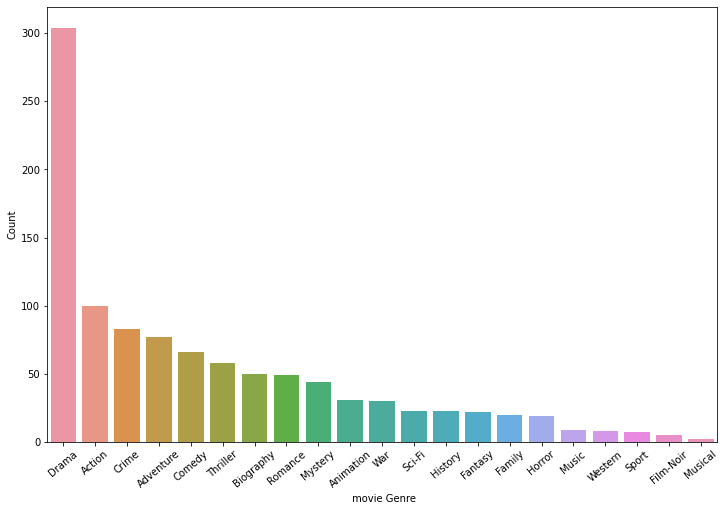

In [210]:
plt.figure(figsize=(12,8))
counts = new_df.Genre.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel(' movie Genre')
plt.ylabel('Count')
plt.xticks(rotation=40);

#### In these histograms you can see the numeric data in ranges, where each bar represents how frequently numbers fall into a particular range.

array([[<AxesSubplot:title={'center':'Rating'}>,
        <AxesSubplot:title={'center':'Votes'}>],
       [<AxesSubplot:title={'center':'Runtime'}>, <AxesSubplot:>]],
      dtype=object)

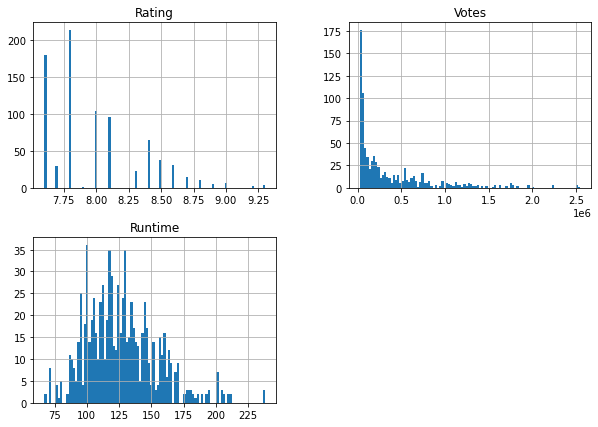

In [211]:
fig_size=(20,15)
train_set.hist(bins=100, figsize=(10,7))

## 5- Searching for Correlation

Correlation is a term used to represent the statistical measure of linear relationship between two variables. 
It can also be defined as the measure of dependence between two different variables. 
If there are multiple variables and the goal is to find correlation between all of these variables and store them using appropriate data structure, the matrix data structure is used.

array([[<AxesSubplot:xlabel='Rating', ylabel='Rating'>,
        <AxesSubplot:xlabel='Votes', ylabel='Rating'>,
        <AxesSubplot:xlabel='Runtime', ylabel='Rating'>],
       [<AxesSubplot:xlabel='Rating', ylabel='Votes'>,
        <AxesSubplot:xlabel='Votes', ylabel='Votes'>,
        <AxesSubplot:xlabel='Runtime', ylabel='Votes'>],
       [<AxesSubplot:xlabel='Rating', ylabel='Runtime'>,
        <AxesSubplot:xlabel='Votes', ylabel='Runtime'>,
        <AxesSubplot:xlabel='Runtime', ylabel='Runtime'>]], dtype=object)

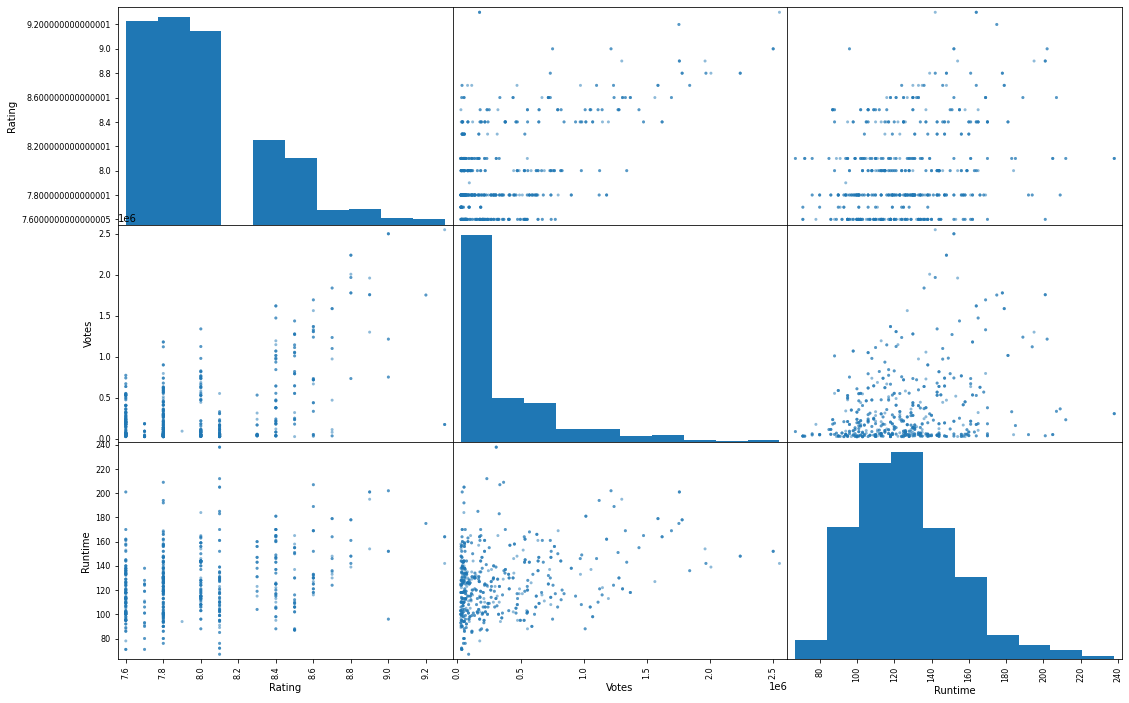

In [212]:
scatter_matrix(train_set, figsize=(18, 12))

#### Scatterplots show possible associations or relationships between two variables. We can see that there is a moderate positive relationship between the Rating and Votes.

<AxesSubplot:>

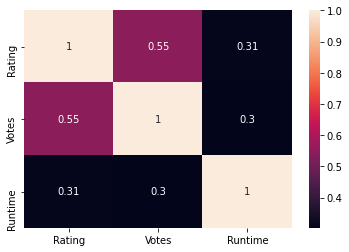

In [213]:
sns.heatmap(train_set.corr(), annot = True)

#### According to the heatmap, we can see that there is a partial correlation between the rating and the amount of votes. In comparison to other variables from the dataset, the amount of votes has greater correlation than the rest of the categories.

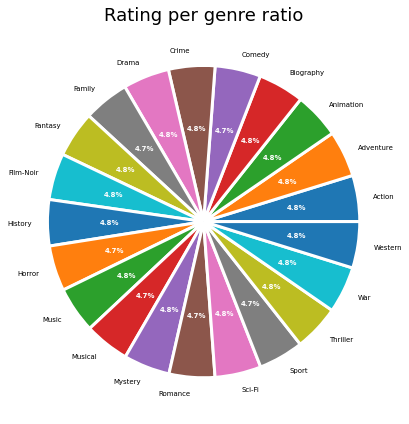

In [181]:
fig, ax = plt.subplots(figsize=(6, 6))

grouped_genre = new_df.groupby("Genre")
genre_df = grouped_genre.mean()
genre_df = genre_df.reset_index()

x= genre_df['Rating']
labels= genre_df['Genre']

# Capture each of the return elements
patches, texts, pcts = ax.pie(
    x, labels=labels, autopct='%.1f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-small'})

# Style the percent values
plt.setp(pcts, color='white', fontweight='bold')
ax.set_title('Rating per genre ratio', fontsize=18)
plt.tight_layout()

#### With this pie chart we can see that the average rating per genre is approximately the same for each genre. Therefore, there might be slim to no correlation at all between the two.

# 6- Comparing 3 Models

### R squared scoring explained

We will use R2 as our scoring system. R-squared is a statistical measure of how close the data is to the fitted regression line. It is also known as the coefficient of determination.The r2 score for perfect model is 1.0.
On the other hand, the r2 score for a model which predicts mean value is 0.0.

The formula for calculating R2 is as follows:
R2 = (var(mean) – var(line))/var(mean) = 1-(var(line)/var(mean))

### Linear regression

Linear regression is a linear model, one that assumes a linear relationship between the input variables x and the single output variable y. More specifically, that y can be calculated from a linear combination of the input variables x.

In [214]:
linear_reg = linear_model.LinearRegression()
folds = KFold(n_splits = 14, shuffle = True, random_state = 42)

In [215]:
l_scores = cross_val_score(linear_reg, x_train, y_train, scoring='r2', cv=folds)
print(l_scores)
np.mean(l_scores)

[ 0.1881363   0.33750035  0.30325487  0.50892961  0.45796196  0.30642784
  0.4243119  -0.01950881  0.07887765  0.39544527  0.36085312  0.31850247
  0.36398236  0.32529274]


0.3107119732778595

### K Nearest Neighbor

The KNN algorithm assumes that similar things exist close to one another.
Therefore, KNN tries to predict the correct class for the test data by calculating the distance between the test data and all the training points. Then it selects the K number of points which is closet to the test data.

In [99]:
knn_reg = KNeighborsRegressor()
knn_scores = cross_val_score(knn_reg, x_train, y_train, scoring='r2', cv=folds)
print(knn_scores)
np.mean(knn_scores)

[0.44785613 0.47847663 0.55339034 0.69671968 0.59643658 0.49032598
 0.4073486  0.32850777 0.31931666 0.44460467 0.59165648 0.38081012
 0.44434419 0.49032868]


0.4764373226978444

### Decision Tree Regressor

The process of a Decision Tree Regressor involves many steps, however we will explain the algorithm in simplicity:
A decision tree builds regression models in the form of a tree structure. 
It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. 
The final result is a tree with decision nodes and leaf nodes.

In [217]:
regressor = DecisionTreeRegressor()
dt_scores= cross_val_score(regressor, x_train, y_train, cv=folds, scoring='r2')
print(dt_scores)
np.mean(dt_scores)

[0.66730538 0.80780986 0.79887685 0.80844943 0.79187324 0.80790588
 0.78851915 0.16496194 0.58355071 0.87333927 0.90387568 0.8090218
 0.84041531 0.86800778]


0.7509937346532087

We can conclude that the best results that we are getting are from the Decision Tree Model. 
Therefore, we will choose Decision Tree Model as our test model.

# 7- Evaluating the Chosen Model

We will go-over the max depth values in order to evaluate further the Decision Tree Model and to choose the right max depth. 

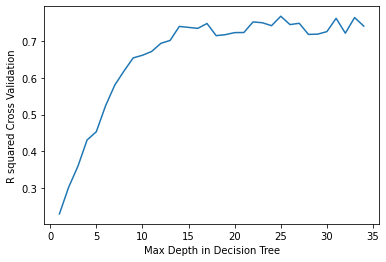

In [113]:
k_range = range(1, 35)
k_scores = []

for k in k_range:
    dtr = DecisionTreeRegressor(max_depth=k)
    scores = cross_val_score(dtr, x_train, y_train, cv=folds, scoring='r2')
    k_scores.append(scores.mean())
    
# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Max Depth in Decision Tree')
plt.ylabel('R squared Cross Validation')
plt.show()

As we can see, by choosing the max depth to be approx. 22, our model will be more precise.

# 8- Dummy Model

The Dummy Regressor is a kind of Regressor that gives prediction based on simple strategies without paying any attention to the input Data.

To understand better how the model performed, the evaluation metric r2_ score is calculated for both the Decision Tree and Dummy Model.

In [137]:
regressor = DecisionTreeRegressor(max_depth=22) 
regressor.fit(x_train, y_train)

dummy_mean = DummyRegressor(strategy = 'mean').fit(x_train, y_train)
y_predict = regressor.predict(x_test)
y_predict_dummy_mean = dummy_mean.predict(x_test)

In [138]:
y_predict

array([7.6, 7.6, 8. , 8. , 7.8, 8.4, 8. , 8.9, 7.7, 7.6, 7.8, 7.6, 7.6,
       7.8, 7.6, 8. , 7.8, 8.7, 8.1, 8.5, 8. , 7.8, 7.8, 7.8, 8. , 8.6,
       7.6, 7.9, 8. , 8. , 7.6, 8.4, 7.8, 8.4, 8.7, 8.4, 8.7, 7.6, 8.1,
       8.6, 7.8, 7.8, 8.6, 7.8, 8. , 7.6, 8. , 7.6, 8.4, 8.1, 7.8, 7.8,
       7.6, 8. , 7.8, 7.8, 8.6, 7.7, 8. , 8.5, 8. , 8. , 7.6, 8. , 8.1,
       7.6, 8.4, 8.7, 8. , 7.8, 7.6, 7.6, 8. , 8.3, 7.6, 7.6, 8. , 8.3,
       8.7, 7.8, 7.6, 7.6, 7.8, 7.8, 8.7, 7.8, 8.5, 7.6, 8.5, 8.4, 8. ,
       8. , 8.5, 8. , 8.4, 7.8, 8.5, 7.6, 7.8, 7.6, 8.4, 7.8, 8.4, 7.6,
       8.1, 8.5, 7.6, 7.6, 8. , 7.8, 8.7, 8.5, 7.8, 7.6, 8.9, 7.8, 7.6,
       8.1, 8.9, 8.4, 7.8, 8.4, 7.8, 7.8, 8.3, 8.7, 8. , 7.6, 8.1, 8.4,
       7.6, 7.6, 8.1, 7.8, 8.1, 7.6, 7.8, 7.8, 7.8, 8. , 8.4, 8.5, 7.6,
       8. , 7.8, 7.8, 7.6, 7.6, 7.6, 7.8, 7.6, 8.1, 8.4, 8.6, 7.8, 8. ,
       7.6, 7.6, 8. , 8. , 7.8, 8.1, 8.6, 8. , 7.6, 8.6, 8. , 8.5, 7.6,
       8. , 7.8, 8.3, 8.1, 7.8, 7.7, 8. , 8.5, 8.1, 8.4, 7.6, 8.

In [139]:
print("R squared score for Dummy Model): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))

r2_score (Dummy Percision): -0.00


We can see that our Dummy Models' R squared score is as supposed to be.

# 9- Testing our model & analyzing

In [141]:
# test the dataset
y_pred = regressor.predict(x_test)
print("r2_score (Decision Tree Percision): {:.2f}".format(r2_score(y_test, y_predict)))

r2_score (Decision Tree Percision): 0.83


In comparison to the Dummy Model, we can see that the Decision Tree is approximately 83% percise. 
Meaning that our model did quite well on predicting the audience rating in comparison to the data it was given.